# Making a connectivity matrix from the Fruit Fly connectome

Using Janelia's data

In [68]:
import pandas as pd
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [10,6]) # paper figures should be width 10 (full linewidth) to have nicely readable text

In [2]:
neurons = pd.read_csv('janelia-data/traced-neurons.csv')
connections = pd.read_csv('janelia-data/traced-total-connections.csv')
neurons

,bodyId,type,instance
0,200326126,CL141,CL141_L
1,202916528,FS4C,FS4C(FQ12)_C4_R
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R
3,203253253,SMP505,SMP505(PDM22)_L
4,203257652,FS4C,FS4C(FQ12)_C6_R
...,...,...,...
21734,7112579856,LC20,LC20
21735,7112615127,AVLP335,AVLP335_R
21736,7112617294,AVLP331,AVLP331_R
21737,7112622044,LAL137,LAL137(PVL05)_L


In [155]:
pen1 = neurons[neurons.type == 'PEN_a(PEN1)'].sort_values('instance')
pen2 = neurons[neurons.type == 'PEN_b(PEN2)'].sort_values('instance')
# sort pen1 and pen2 together
pen = pd.concat((pen1, pen2)).loc[pd.concat((pen1, pen2)).instance.apply(lambda x: x[-2:]).sort_values().index]
peg = neurons[neurons.type == 'PEG'].sort_values('instance')
epg = neurons[neurons.type == 'EPG'].sort_values('instance')
d7 = neurons[neurons.type == 'Delta7'].sort_values('instance')

# flip the sorting of neurons on right side (ie. L1, L2, ..., L9, R9, ..., R1)
pen = pen.sort_values(by='instance', key=lambda column: column.apply(lambda instance: int(instance[-1]) if instance[-2] == 'L' else 100-int(instance[-1])))
peg = peg.sort_values(by='instance', key=lambda column: column.apply(lambda instance: int(instance[-1]) if instance[-2] == 'L' else 100-int(instance[-1])))
epg = epg.sort_values(by='instance', key=lambda column: column.apply(lambda instance: int(instance[-1]) if instance[-2] == 'L' else 100-int(instance[-1])))

ids = list(pd.concat((pen.bodyId, peg.bodyId, epg.bodyId, d7.bodyId)))
ids_set = set(ids) # faster to call `in` for a set

In [156]:
# get the rows of the connections table that we care about
connections_subset = connections.iloc[[pre_id in ids_set and post_id in ids_set for pre_id, post_id in zip(connections.bodyId_pre, connections.bodyId_post)]]
connections_subset

,bodyId_pre,bodyId_post,weight
229804,387364605,789126240,1
229810,387364605,1065409934,1
229813,387364605,912545106,3
229815,387364605,1035045015,1
229818,387364605,911565419,1
...,...,...,...
3459269,5813080838,5813056953,25
3459273,5813080838,1220576923,8
3459275,5813080838,973566036,43
3459277,5813080838,911578496,35


In [157]:
# convert the table to a connectivity matrix [pre,post]
connectivity_matrix = np.zeros((len(ids),len(ids)))

for pre_id, post_id, weight in connections_subset.itertuples(index=False):
	connectivity_matrix[ids.index(pre_id), ids.index(post_id)] = weight

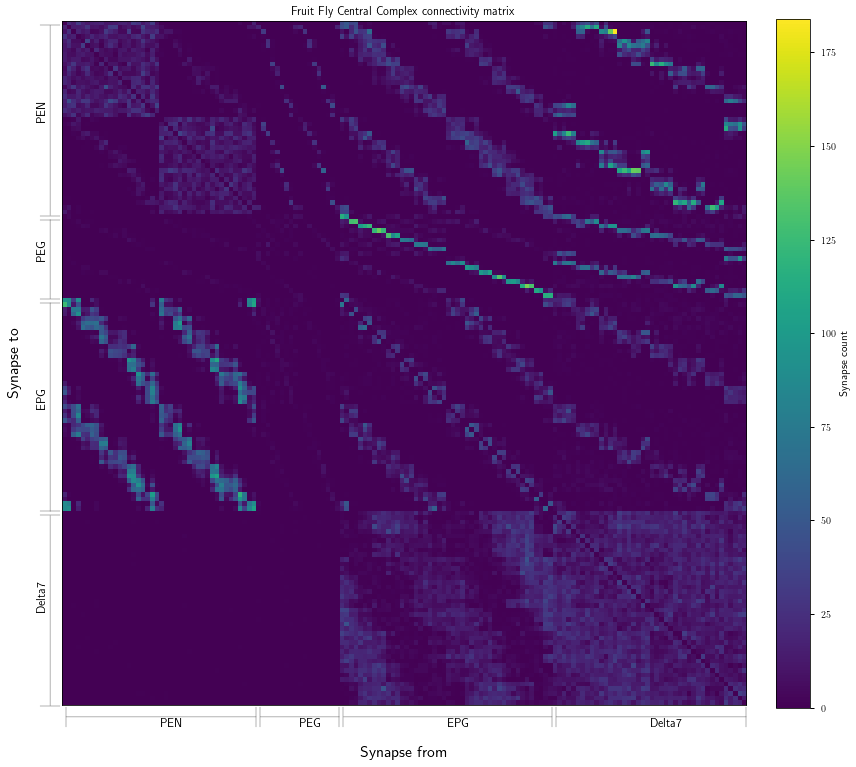

In [158]:
plt.figure(figsize=(12,12))
im = plt.imshow(connectivity_matrix.T)
plt.xlabel('\n\nSynapse from', fontsize=16)
plt.ylabel('Synapse to\n\n', fontsize=16)
plt.title('Fruit Fly Central Complex connectivity matrix')
plt.xticks([])
plt.yticks([])

type_borders = np.cumsum([0,len(pen1)+len(pen2),len(peg),len(epg),len(d7)])

for start,stop,type in zip(type_borders[:-1], type_borders[1:],['PEN','PEG','EPG','Delta7']):
	plt.annotate('',xy=(start,150),xytext=(stop,150), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)
	plt.annotate('',xy=(-3,start),xytext=(-3,stop), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)

	plt.annotate(type,xy=((start+stop)/2,152), annotation_clip=False, fontsize=12)
	plt.annotate(type,xy=(-6,(start+stop)/2), annotation_clip=False, fontsize=12, rotation=90)

plt.colorbar(im, fraction=0.046, pad=0.04, label='Synapse count')
plt.tight_layout()
plt.show()

## Group neurons in the same glomeruli

In [163]:
all_instances = pd.concat((
	pen.instance.apply(lambda x: f'1_{x[-2:]}'),
	peg.instance.apply(lambda x: f'2_{x[-2:]}'),
	epg.instance.apply(lambda x: f'3_{x[-2:]}'),
	d7.instance.apply(lambda x: f'4_{x.split("_")[1][:2]}') # note: D7 mixes some slightly different neurons eg. L4R5 and L4R6...
))

neuron_groups, unique_indices, neuron_group_indices = np.unique(all_instances, return_index=True, return_inverse=True)
neuron_groups = neuron_groups[np.argsort(unique_indices)]

In [164]:
neuron_groups

array(['1_L2', '1_L3', '1_L4', '1_L5', '1_L6', '1_L7', '1_L8', '1_L9',
       '1_R9', '1_R8', '1_R7', '1_R6', '1_R5', '1_R4', '1_R3', '1_R2',
       '2_L1', '2_L2', '2_L3', '2_L4', '2_L5', '2_L6', '2_L7', '2_L8',
       '2_L9', '2_R9', '2_R8', '2_R7', '2_R6', '2_R5', '2_R4', '2_R3',
       '2_R2', '2_R1', '3_L1', '3_L2', '3_L3', '3_L4', '3_L5', '3_L6',
       '3_L7', '3_L8', '3_R8', '3_R7', '3_R6', '3_R5', '3_R4', '3_R3',
       '3_R2', '3_R1', '4_L1', '4_L2', '4_L3', '4_L4', '4_L5', '4_L6',
       '4_L7', '4_L8'], dtype=object)

In [165]:
# create the grouped connectivity_matrix
connectivity_matrix_grouped = np.zeros((len(neuron_groups), len(neuron_groups)))

for pre_id, post_id, weight in connections_subset.itertuples(index=False):
	connectivity_matrix_grouped[neuron_group_indices[ids.index(pre_id)], neuron_group_indices[ids.index(post_id)]] += weight

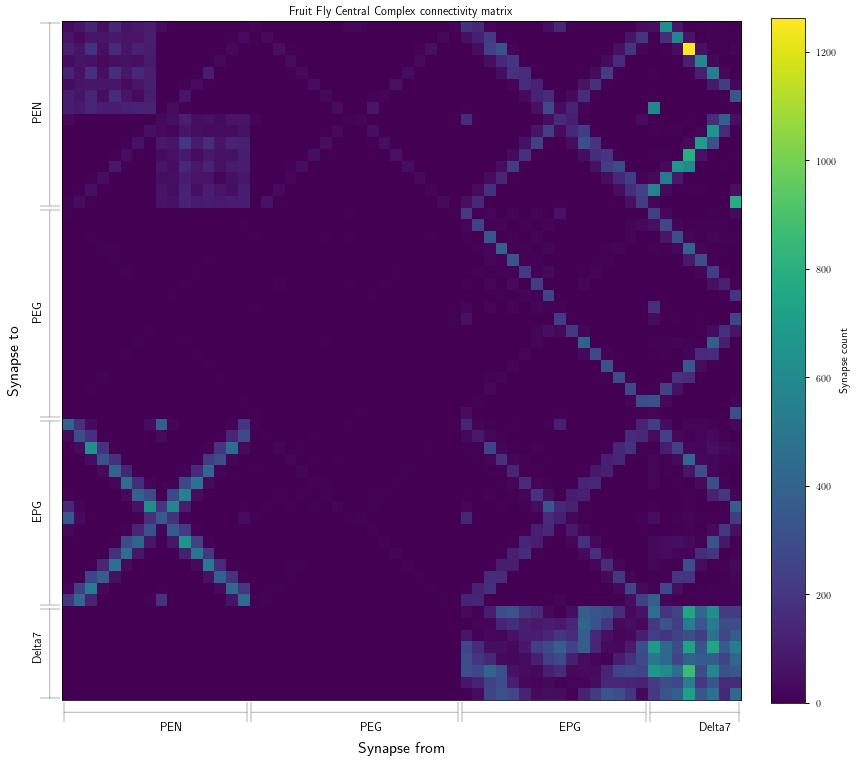

In [166]:
plt.figure(figsize=(12,12))
im = plt.imshow(connectivity_matrix_grouped.T)
plt.xlabel('\n\nSynapse from', fontsize=16)
plt.ylabel('Synapse to\n\n', fontsize=16)
plt.title('Fruit Fly Central Complex connectivity matrix')
plt.xticks([])
plt.yticks([])

type_borders = np.cumsum([0,16,18,16,8])

for start,stop,type in zip(type_borders[:-1], type_borders[1:],['PEN','PEG','EPG','Delta7']):
	plt.annotate('',xy=(start-.5,58.5),xytext=(stop-.5,58.5), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)
	plt.annotate('',xy=(-1.5,start-.5),xytext=(-1.5,stop-.5), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)

	plt.annotate(type,xy=((start+stop)/2,60), annotation_clip=False, fontsize=12)
	plt.annotate(type,xy=(-3,(start+stop)/2), annotation_clip=False, fontsize=12, rotation=90)

plt.colorbar(im, fraction=0.046, pad=0.04, label='Synapse count')
plt.tight_layout()
plt.show()